In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

In [3]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220328_WT_sampling.h5ad' # for full, can maybe get away with ~300G
    %memit wt = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))


if True :
    start = time.time()
    backed=None # None if not
    fname='220328_SCA1_sampling.h5ad' # for full, can maybe get away with ~300G
    %memit mut = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))


peak memory: 22183.51 MiB, increment: 21986.86 MiB
loaded @220802.12:19:23
took 22.81-s to load data
peak memory: 44299.29 MiB, increment: 22115.76 MiB
loaded @220802.12:19:45
took 22.09-s to load data


In [4]:
# subset by cell type, i 
i = 'PC'
wt = wt[wt.obs['sub4']==i, :]
wt.obs['value'] = 0
mut = mut[mut.obs['sub4']==i, :]
mut.obs['value'] = 0

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [5]:
    # get list of genes
goi = pd.read_csv(os.path.join(pfp, '220803 PC DEG for heatmap_all timepoints.csv'), header=None)[0].to_list()


In [24]:
X = pd.DataFrame(wt[:,goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi, dtype=float)
X['batch'] = wt.obs['batch'].astype(str)+ '_' +wt.obs['timepoint'].astype(str)  + '_' + wt.obs['genotype'].astype(str) 

dt = pd.DataFrame(mut[:,goi].layers['imputed'], index=mut.obs.index.to_list(), columns=goi, dtype=float)
dt['batch'] = mut.obs['batch'].astype(str) + '_' +mut.obs['timepoint'].astype(str) + '_' + mut.obs['genotype'].astype(str) 

X = X.append(dt) 
X = X.T

In [30]:
ss = pd.DataFrame(wt[:,goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi, dtype=float)
ss['batch'] = wt.obs['batch'].astype(str)+ '_' +wt.obs['timepoint'].astype(str)  + '_' + wt.obs['genotype'].astype(str) 

ss['batch'].unique()

array(['7202_5wk_WT', '72921_5wk_WT', '72922_5wk_WT', '22018_12wk_WT',
       '2061_12wk_WT', '2062_12wk_WT', '6569_18wk_WT', '65701_18wk_WT',
       '65702_18wk_WT', '1974_24wk_WT', '2020_24wk_WT', '20202_24wk_WT',
       '5812_30wk_WT', '58232_30wk_WT', '5822_30wk_WT'], dtype=object)

In [33]:
# aesthetics
    
cmap_batch = {'7202_5wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[1],
              '72921_5wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[1], 
              '72922_5wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[1], 
              '22018_12wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[2],
              '2061_12wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[2],
              '2062_12wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[2],
              '6569_18wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[3],
              '65701_18wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[3],
              '65702_18wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[3],
              '1974_24wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[4],
              '2020_24wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[4],
              '20202_24wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[4],
              '5812_30wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[5],
              '58232_30wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[5],
              '5822_30wk_WT':sns.cubehelix_palette(8,start=.5,rot=-.75)[5],
              '7294_5wk_SCA1':sns.cubehelix_palette(8)[1],
              '72931_5wk_SCA1':sns.cubehelix_palette(8)[1],
              '72932_5wk_SCA1':sns.cubehelix_palette(8)[1],
              '22019_12wk_SCA1':sns.cubehelix_palette(8)[2],
              '2063_12wk_SCA1':sns.cubehelix_palette(8)[2],
              '2065_12wk_SCA1':sns.cubehelix_palette(8)[2],
              '6571_18wk_SCA1':sns.cubehelix_palette(8)[3],
              '65731_18wk_SCA1':sns.cubehelix_palette(8)[3],
              '65732_18wk_SCA1':sns.cubehelix_palette(8)[3],
              '1589_24wk_SCA1':sns.cubehelix_palette(8)[4],
              '2021_24wk_SCA1':sns.cubehelix_palette(8)[4],
              '20212_24wk_SCA1':sns.cubehelix_palette(8)[4],
              '58231_30wk_SCA1':sns.cubehelix_palette(8)[5],
              '58241_30wk_SCA1':sns.cubehelix_palette(8)[5],
              '58242_30wk_SCA1':sns.cubehelix_palette(8)[5],}



In [34]:
Y = X.T
y = pd.DataFrame(Y.loc[:, [i for i in Y.columns.to_list() if 'batch' not in i]], dtype=float)
y['batch'] = Y['batch']
y = y.groupby('batch').mean().reset_index().T
y.columns = y.iloc[0, :]
y = y.drop(y.index[0])
del Y

In [35]:
col_col = X.loc[X.index=='batch', :].T['batch'].map(cmap_batch).to_list()
X = X.loc[~(X.index=='batch'), :]

In [36]:

X.loc[:, :] = np.asarray(X.loc[:, :], dtype='float')

/gpfs/ysm/project/lim_janghoo/cl2292/conda_envs/sc_tutorial/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-36-43d0321548a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, :] = np.asarray(X.loc[:, :], dtype='float')


In [37]:

y.loc[:, :] = np.asarray(y.loc[:, :], dtype='float')

/gpfs/ysm/project/lim_janghoo/cl2292/conda_envs/sc_tutorial/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


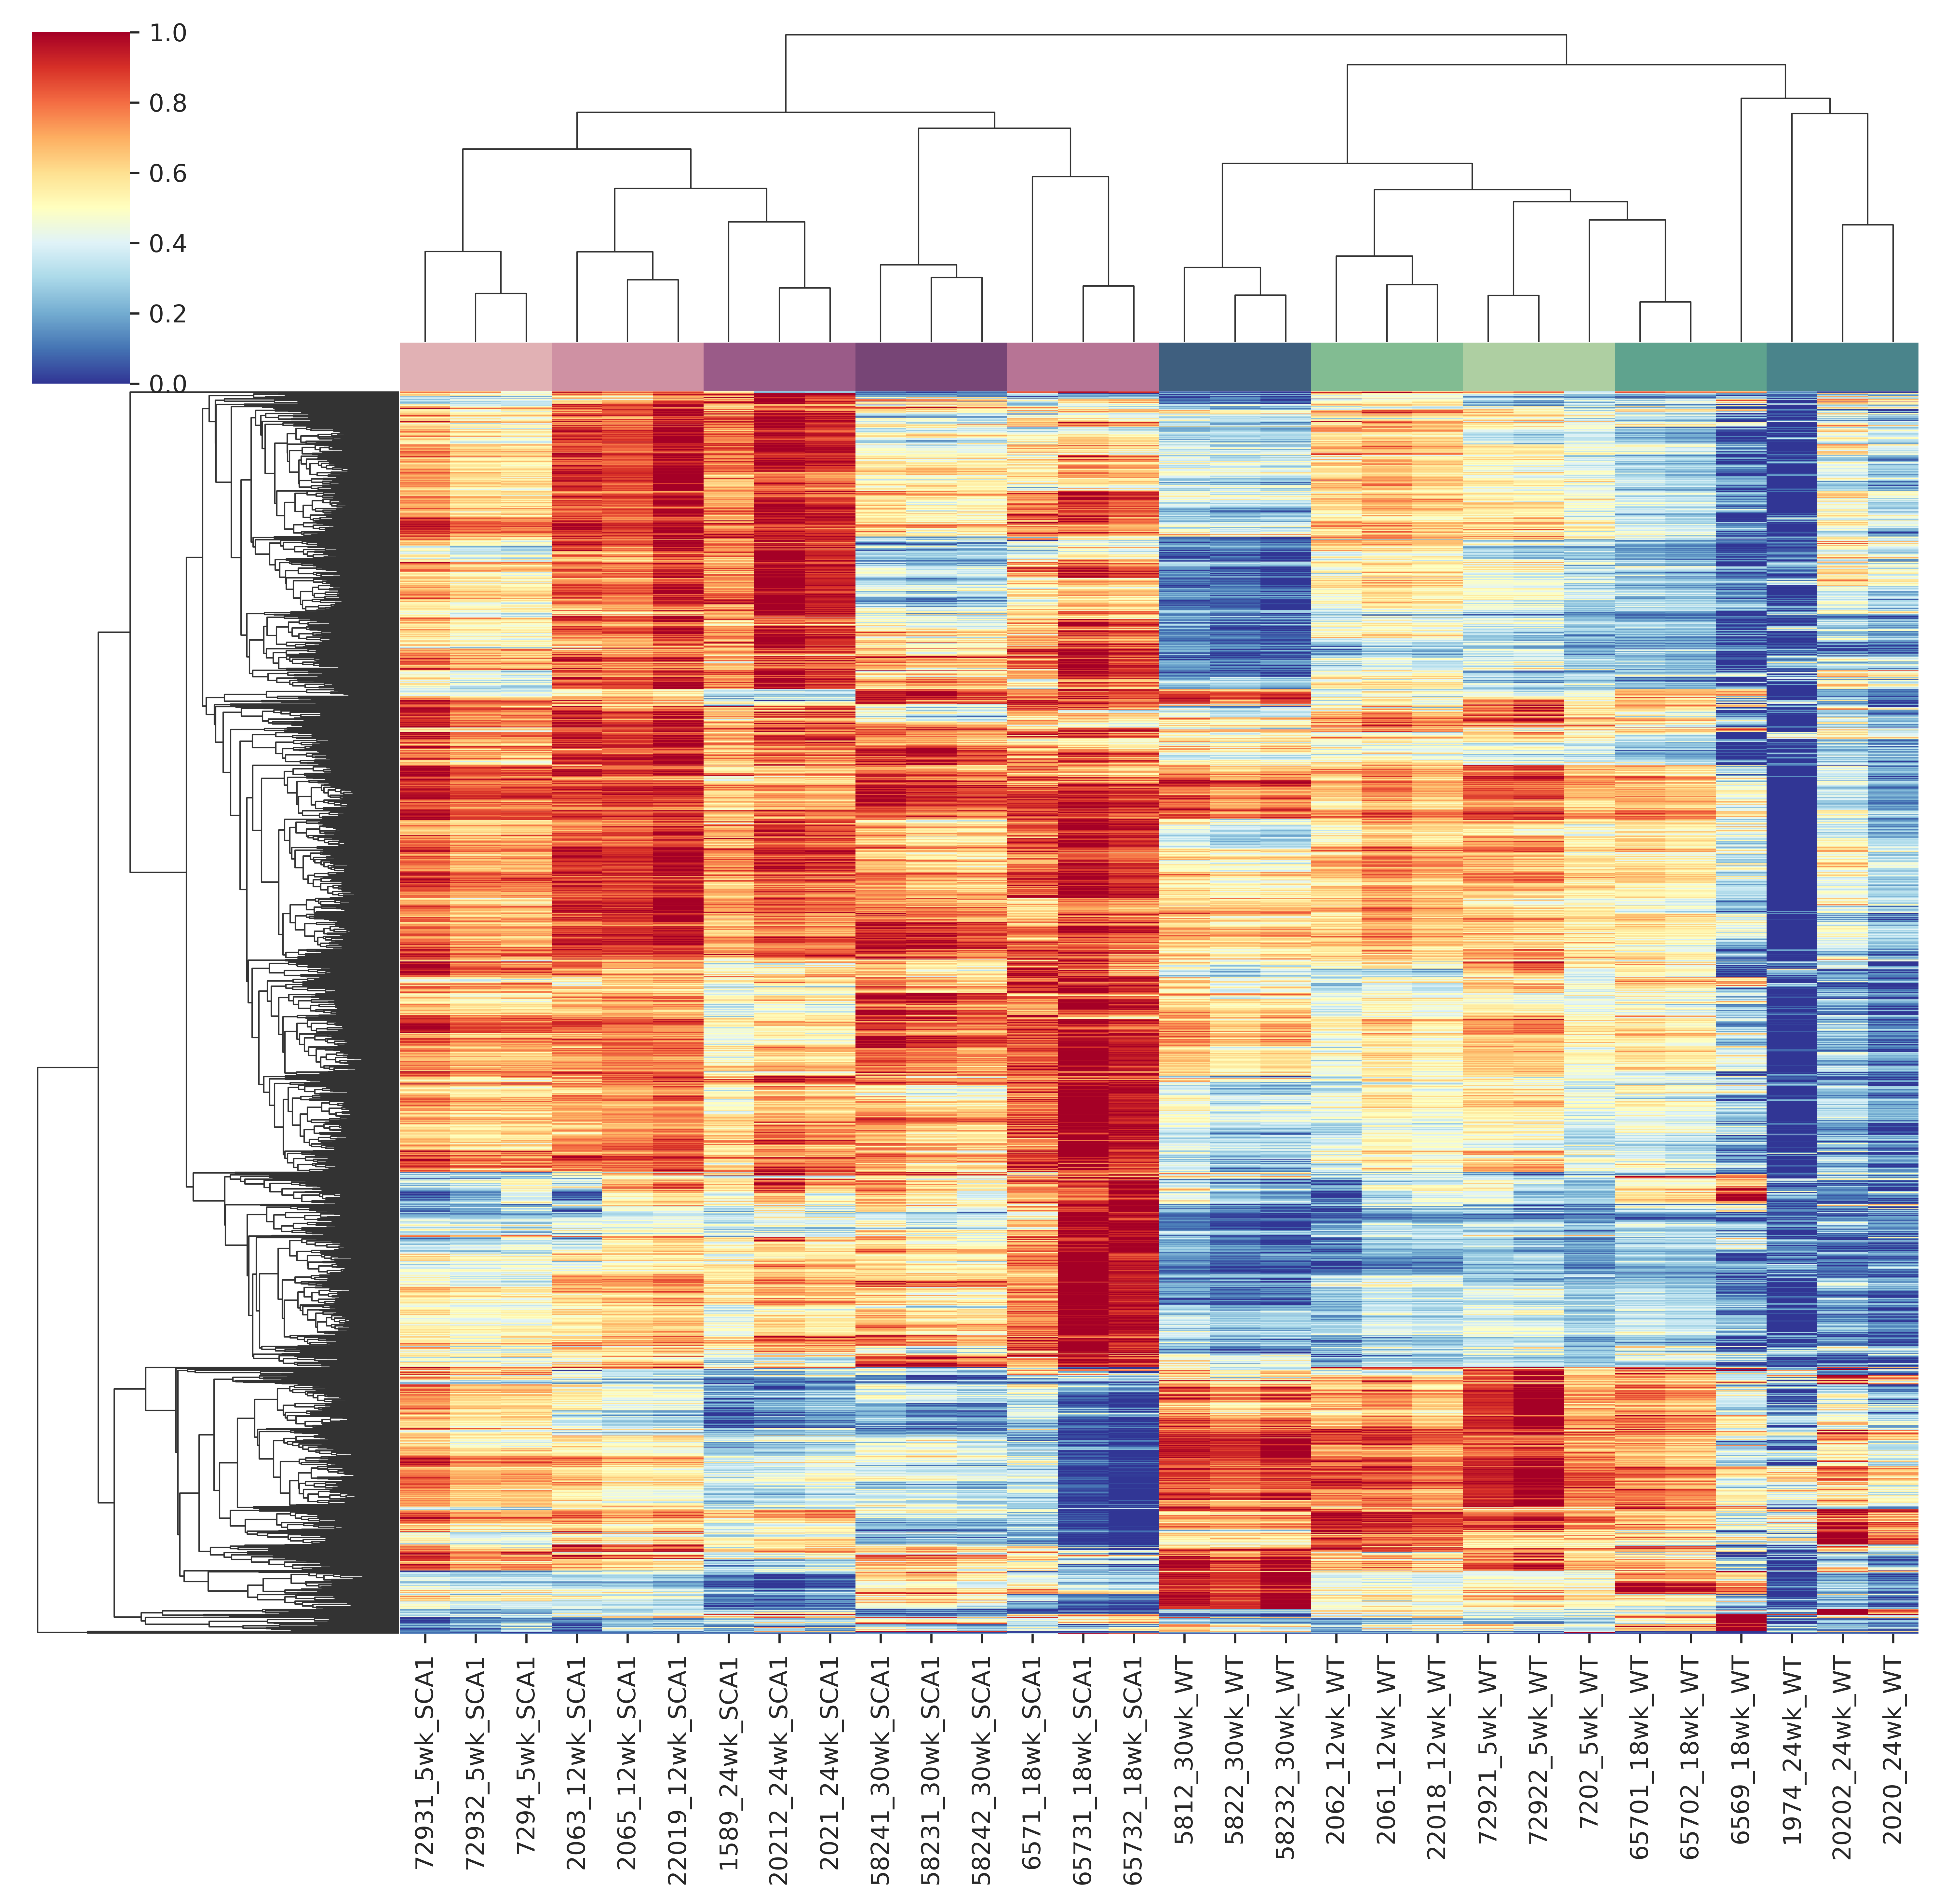

In [38]:
pg = sns.clustermap(y, 
                    col_colors=list(map(cmap_batch.get, y.columns.to_list())),
                    cmap='RdYlBu_r', xticklabels=True, yticklabels=False,
                    standard_scale=0)
pg.ax_heatmap.set_xlabel('')
pg.savefig(os.path.join(pfp, '220803_heatmap_dge_PC_individual_animal.pdf'))